**Import Libraries**

In [1]:
import os
import glob
import cv2
import torch
import random
from PIL import Image
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from torchvision import transforms
from torchvision.models import resnet152, mobilenet_v3_small
from torchsummary import summary
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Set Device and Seed**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**Model and Dataset path**

In [6]:
img_path = '/content/drive/MyDrive/ML-Data/ML Project Dataset - train'
label_path = '/content/drive/MyDrive/ML-Data/Train_Data.csv'
model_task1_path = '/content/drive/MyDrive/ML-Data/weights'
model_task2_path = '/content/drive/MyDrive/ML-Data/task2_weights'

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label_df, label_column, transform=None):
        self.root_dir = root_dir
        self.label_df = label_df
        self.transform = transform
        self.data = self.read_annotations(label_column)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def read_annotations(self, label_column):
        image_list = list(self.label_df['Image_name'])
        label_list = list(self.label_df[label_column])

        data = [(img, label) for img, label in zip(image_list, label_list)]

        return data

In [8]:
class CNNModel(nn.Module):
    def __init__(self, output_dim):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2)  # Output: (112, 112, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (56, 56, 64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Output: (56, 56, 64)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)  # Output: (56, 56, 128)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=4, padding=1)  # Output: (14, 14, 256)
        self.bn6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Output: (14, 14, 256)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU()

        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # Output: (7, 7, 512)
        self.bn8 = nn.BatchNorm2d(512)
        self.relu8 = nn.ReLU()

        # Average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Output: (1, 1, 512)
        self.fc = nn.Linear(512, output_dim)  # Output: (output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.bn6(x)

        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu7(x)

        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.softmax(x)
        return x


In [9]:
class CustomMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV3, self).__init__()
        # Load the pre-trained MobileNet-V3 model with frozen weights
        mobile = mobilenet_v3_small(pretrained=True)

        # Freeze all layers except the classification layer
        for param in mobile.parameters():
            param.requires_grad = False

        num_ftrs = mobile.classifier[-1].in_features
        mobile.classifier[-1] = nn.Linear(num_ftrs, num_classes)

        self.model = mobile


    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
class CustomResNet152Frozen(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet152Frozen, self).__init__()
        # Load the pre-trained ResNet-152 model with frozen weights
        resnet = resnet152(pretrained=True)

        # Freeze all layers except the classification layer
        for param in resnet.parameters():
            param.requires_grad = False

        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_classes)

        self.model = resnet

    def forward(self, x):
        x = self.model(x)
        return x

# Showing Some Examples

In [11]:
label_df = pd.read_csv(label_path)
img_list = list(label_df['Image_name'])
img_count = len(img_list)

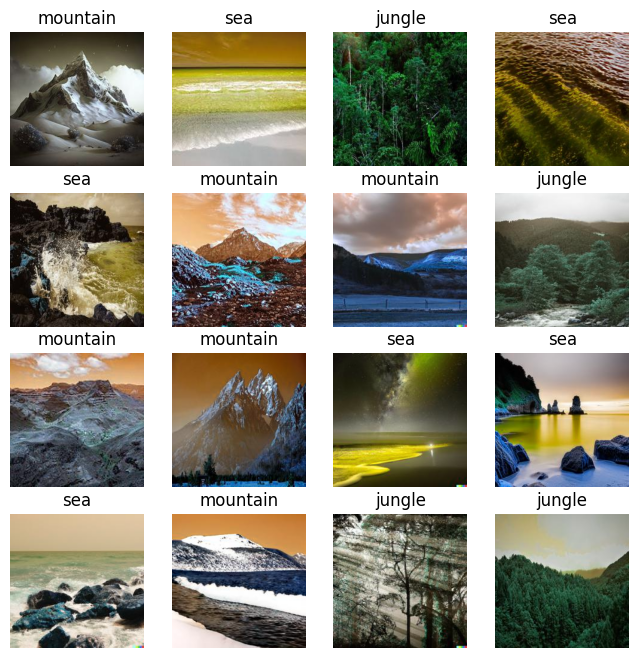

In [12]:
fig = plt.figure(figsize=(8, 8))
row = column = 4
for i in range(1, row * column + 1):
    index = random.randint(0, img_count)
    img_name = img_list[index]
    path = os.path.join(img_path, img_name)
    img = cv2.imread(path)
    fig.add_subplot(row, column, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_df['Nature_label'][index])
plt.show()

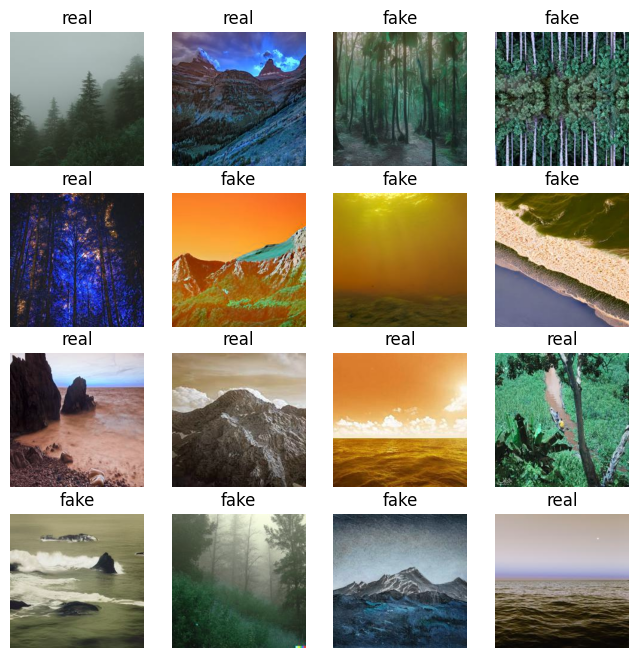

In [13]:
fig = plt.figure(figsize=(8, 8))
row = column = 4
for i in range(1, row * column + 1):
    index = random.randint(0, img_count)
    img_name = img_list[index]
    path = os.path.join(img_path, img_name)
    img = cv2.imread(path)
    fig.add_subplot(row, column, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label_df['Fake_label'][index])
plt.show()

# Inference

In [16]:
df = pd.read_csv('/content/drive/MyDrive/ML-Data/val_dataset.csv')

In [17]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Image_name,Nature_label,Fake_label,Fake_cat,Nature_cat
0,679,679,810100473_fake_stable_jungle_5.jpeg.jpg,0,0,fake,jungle
1,1637,1637,810101356_fake_dream_jungle_3.jpg,0,0,fake,jungle
2,568,568,810100457_fake_stable_sea_4.jpg,2,0,fake,sea
3,790,790,810101066_fake_dalle_sea_1.jpg,2,0,fake,sea
4,1767,1767,810198346_fake_stable_sea_3.jpg,2,0,fake,sea


In [18]:
image_list = list(df['Image_name'])
label_list_fake = list(df['Fake_label'])
label_list_nature = list(df['Nature_label'])

In [20]:
# to tensor transform
transform = transforms.Compose([
        transforms.ToTensor(),
    ])
im = transform(image)

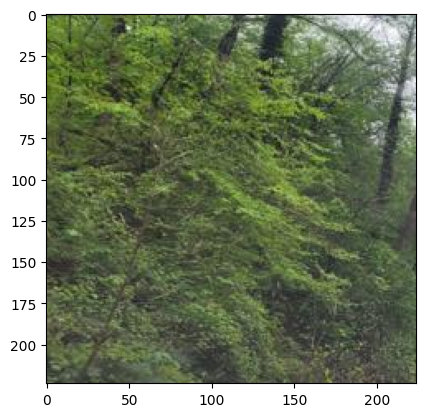

In [19]:
# image loading
path = os.path.join(img_path, image_list[6])
image = Image.open(path).convert('RGB')
plt.imshow(image)

In [29]:
test_dataset_real = CustomDataset(img_path, df, 'Fake_label', transform)
test_dataset_nature = CustomDataset(img_path, df, 'Nature_label', transform )

In [30]:
test_loader_real = DataLoader(test_dataset_real, batch_size=32, shuffle=False)
test_loader_nature = DataLoader(test_dataset_nature, batch_size=32, shuffle=False)

## Nature Task

In [14]:
available_models = glob.glob(model_task1_path + '/*.pth')
available_models

['/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_No_Augmentation.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_ColorJitter.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_RandomRotation.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_VerticalFlip.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_RandomCrop.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_GaussianBlur.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_Grayscale.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_mixup.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_HorizontalFlip.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomMobileNetV3_No_Augmentation.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomMobileNetV3_ColorJitter.pth',
 '/content/drive/MyDrive/ML-Data/weights/CustomMobileNetV3_RandomRotation.pth',
 '/content/drive/MyDrive/ML-Da

### Custom CNN

In [ ]:
model_path = '/content/drive/MyDrive/ML-Data/weights/CNNModel_RMSprop.pth'
model = CNNModel(3)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
clear_output()

### ResNet-152

In [15]:
model_path = '/content/drive/MyDrive/ML-Data/weights/CustomResNet152Frozen_SGD.pth'
model = CustomResNet152Frozen(3)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
clear_output()

In [ ]:
total_test = 0
correct_test = 0
all_labels_test = []
all_predictions_test = []
with torch.no_grad():
            for inputs, labels in test_loader_real:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs_test = model(inputs)

                _, predicted_test = torch.max(outputs_test.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

                all_labels_test.extend(labels.cpu().numpy())
                all_predictions_test.extend(predicted_test.cpu().numpy())
            accuracy_val = correct_test / total_test

In [ ]:
accuracy_val

In [ ]:
total_test = 0
correct_test = 0
all_labels_test = []
all_predictions_test = []
with torch.no_grad():
            for inputs, labels in test_loader_nature:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs_test = model(inputs)

                _, predicted_test = torch.max(outputs_test.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

                all_labels_test.extend(labels.cpu().numpy())
                all_predictions_test.extend(predicted_test.cpu().numpy())
            accuracy_val = correct_test / total_test

### MobileNetV3

In [ ]:
model_path = '/content/drive/MyDrive/ML-Data/weights/CustomMobileNetV3_RandomCrop.pth'
model = CustomMobileNetV3(3)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
clear_output()

## Real Task

In [ ]:
available_models = glob.glob(model_task2_path + '/*.pth')
available_models

['/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_No_Augmentation.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_ColorJitter.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_RandomRotation.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_RandomCrop.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_GaussianBlur.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_Grayscale.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_HorizontalFlip.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_VerticalFlip.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_SGD.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_mixup.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_Adam.pth',
 '/content/drive/MyDrive/ML-Data/task2_weights/CustomRe

### Custom CNN

In [ ]:
model_path = '/content/drive/MyDrive/ML-Data/task2_weights/CNNModel_ColorJitter.pth'
model = CNNModel(2)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
clear_output()

### ResNet-152

In [ ]:
model_path = '/content/drive/MyDrive/ML-Data/task2_weights/CustomResNet152Frozen_mixup.pth'
model = CustomResNet152Frozen(2)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
clear_output()

### MobileNetV3

In [ ]:
model_path = '/content/drive/MyDrive/ML-Data/task2_weights/CustomMobileNetV3_Adam.pth'
model = CustomMobileNetV3(2)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()
clear_output()

# Sep